# Análise Exploratóra - PCA e Clustering

## Sobre este notebook

O objetivo deste notebook é identificar a distribuição das variáveis socioeconômicas dos municípios e agrupá-los em clusters a a partir de suas similaridades.

Utilizamos o PCA para reduzir a dimensionalidade do conjunto de dados e em seguida aplicamos o algoritmo K-Means para realizar o agrupamento. 

Pelo método do silhouette score, chegamos ao valor ótimo de k = 2. Utilizamos o algoritmo Boruta no dataset original para prever o valor dos clusters e selecionar o conjunto ótimo de features. Em seguida, rodamos o PCA no conjunto de dados com a melhores features e realizamos uma nova análise de clustering. A segunda análise indicou novamente um número ótimo de k = 2, porém com um silhouette score maior.

Após uma análise minunciosa, identificamos para o problema de negócio fazia mais sentido dividir os municípios em 4 clusters. Fizemos a seleção de um subconjunto de características de maior interesse e fizemos a comparação dos indicadores entre os clusters. Ao final o cluster de maior potencial foi escolhido

# 1) Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from yellowbrick.cluster import silhouette_visualizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

warnings.filterwarnings("ignore")
sns.set_style("white")

# 2) Coleta dos Dados

In [2]:
df = pd.read_csv(r'../Dados/Tabela_final/tabela_final.csv')

# 2) Análise Exploratória

## 2.1) Distribuição dos dados

Foi realizada uma breve análise da distribuição dos dados a fim de identificar possíveis inconsistência e outliers.

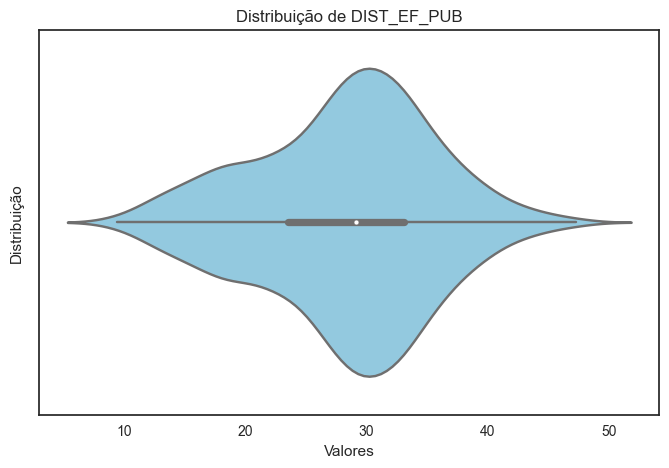

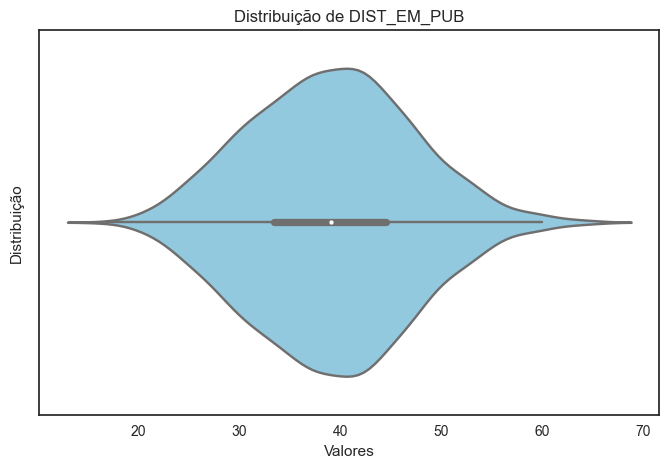

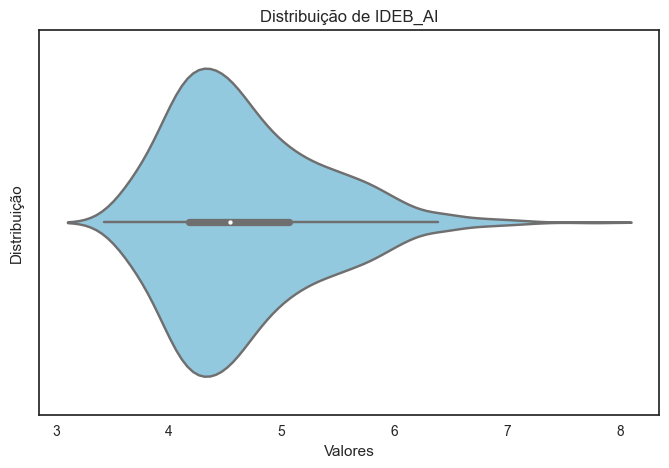

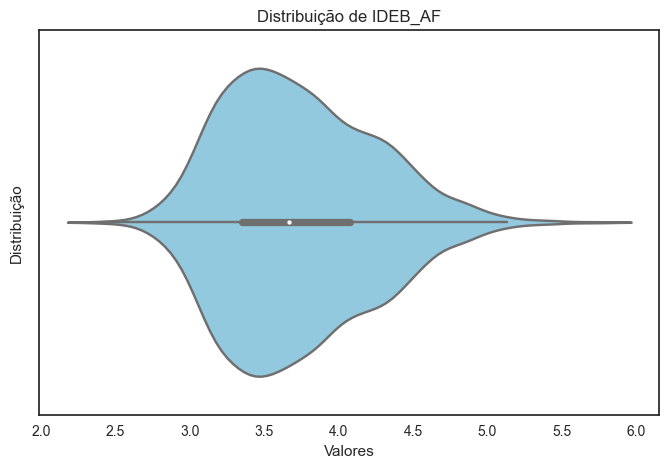

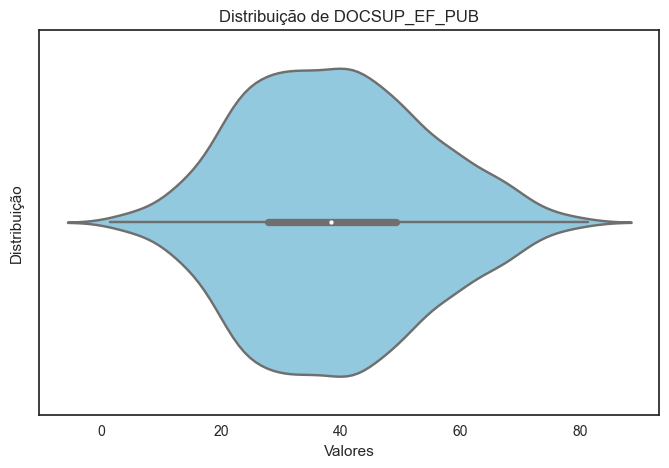

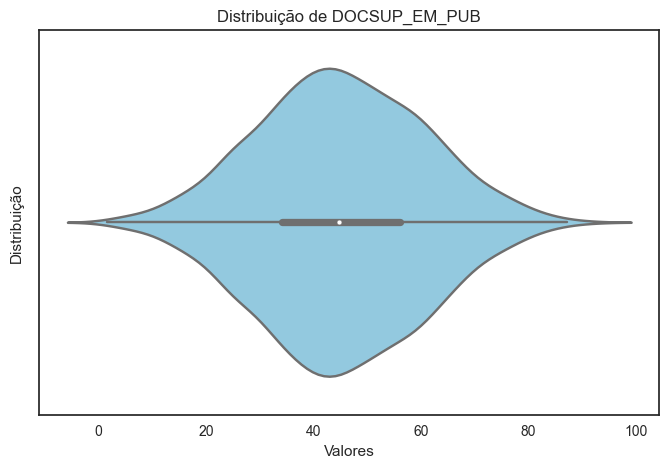

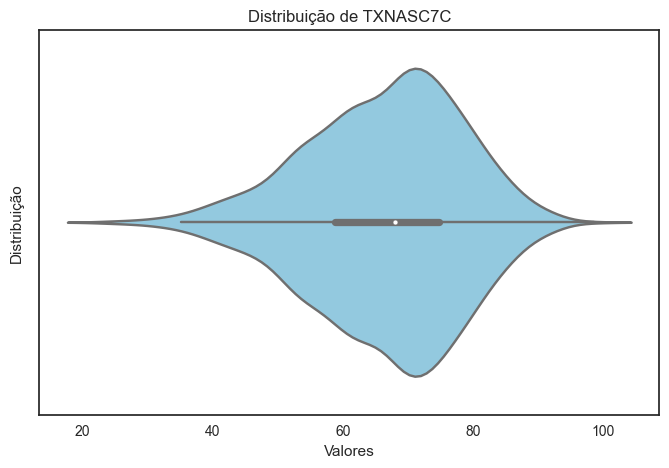

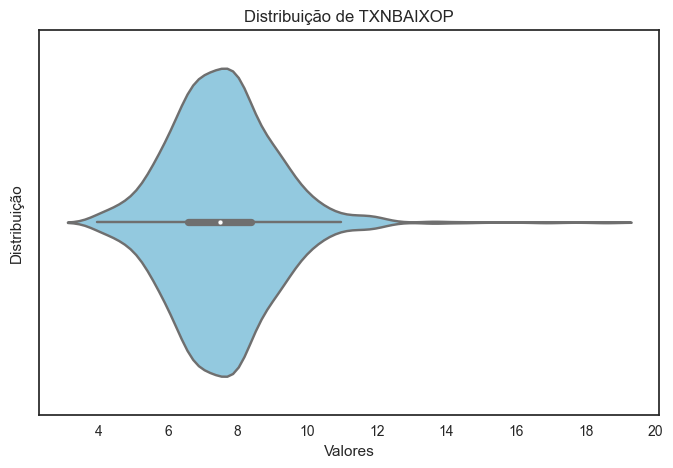

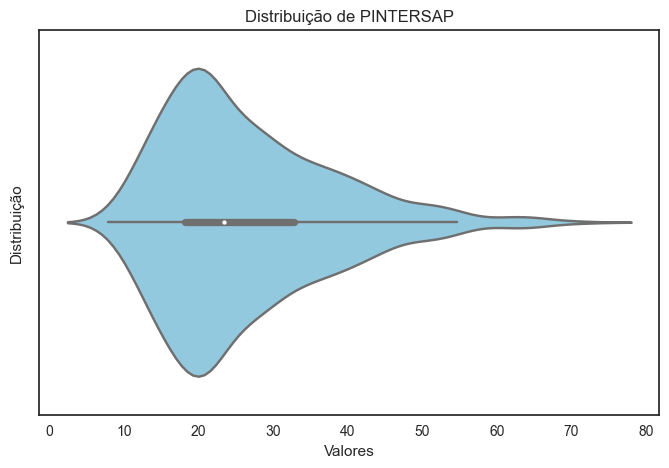

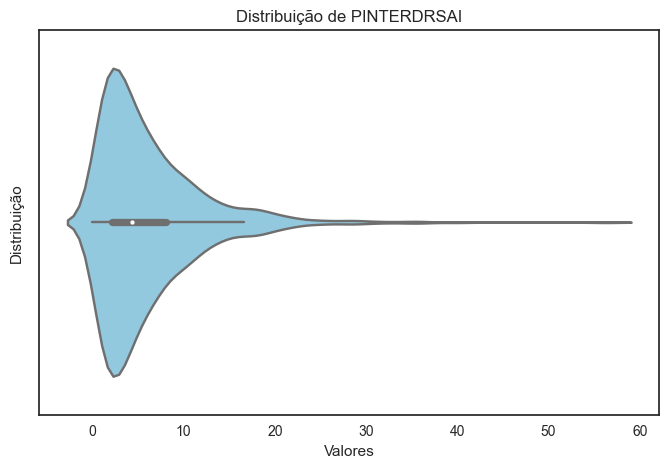

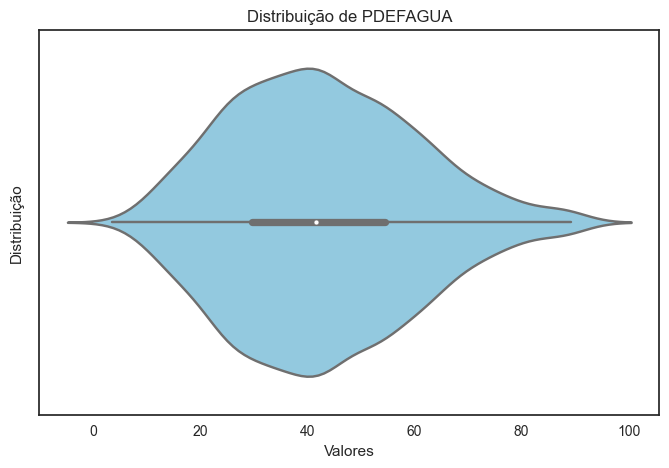

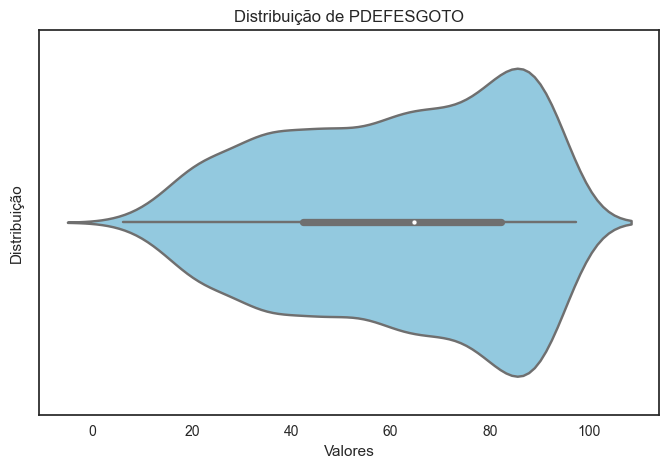

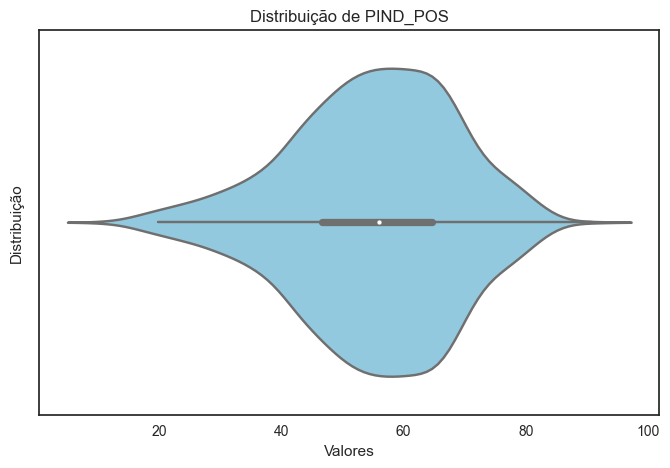

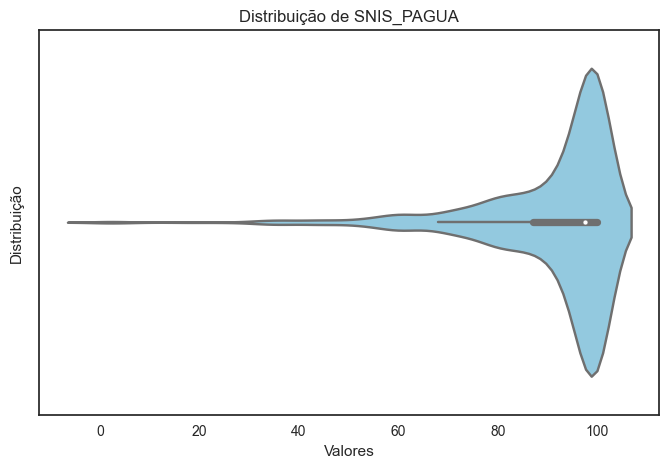

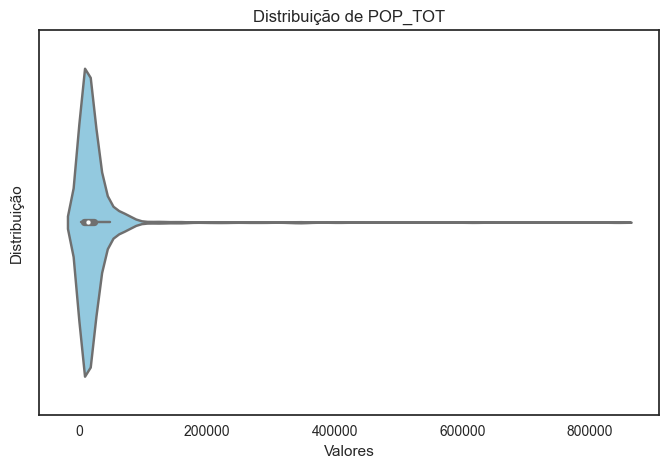

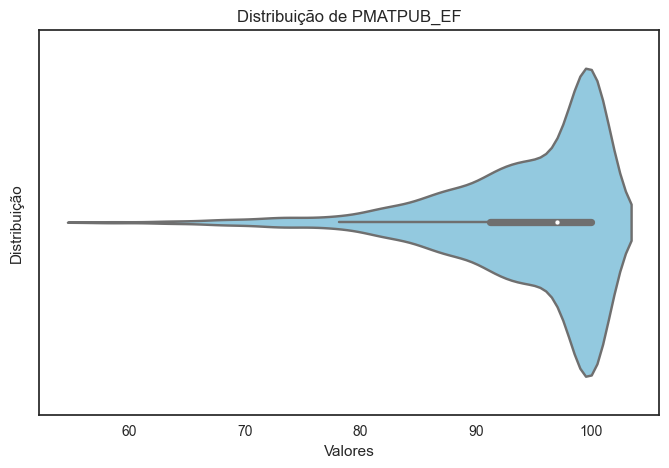

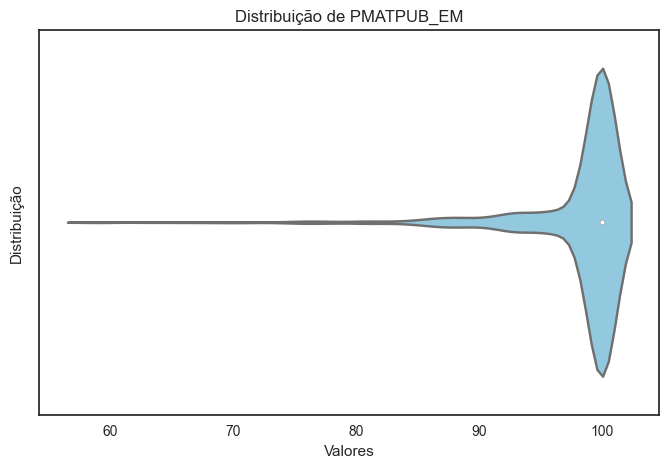

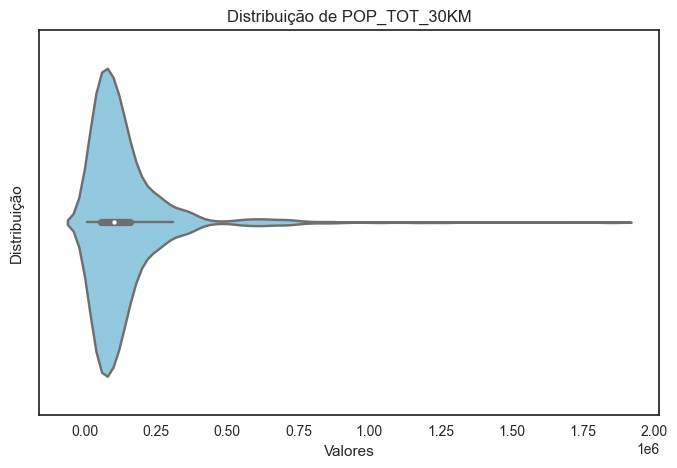

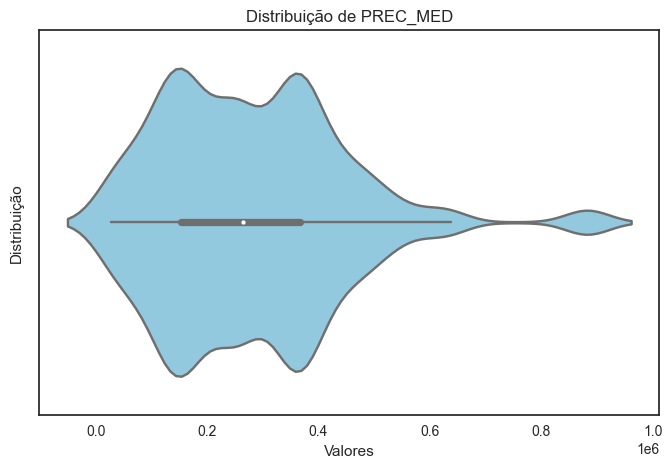

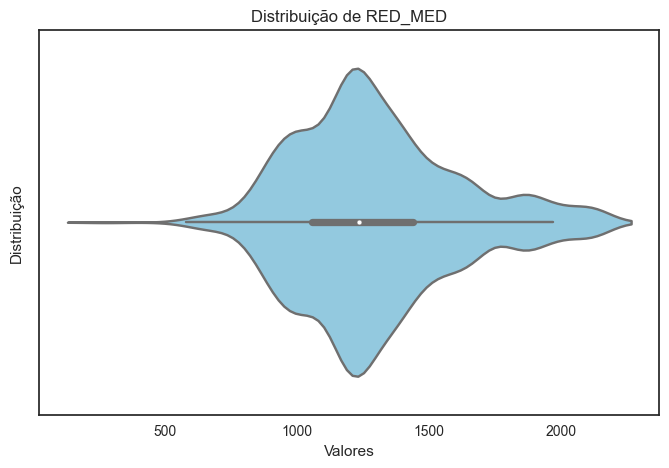

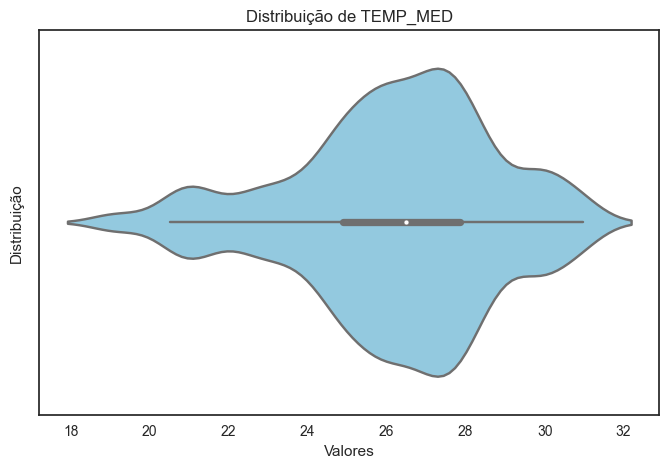

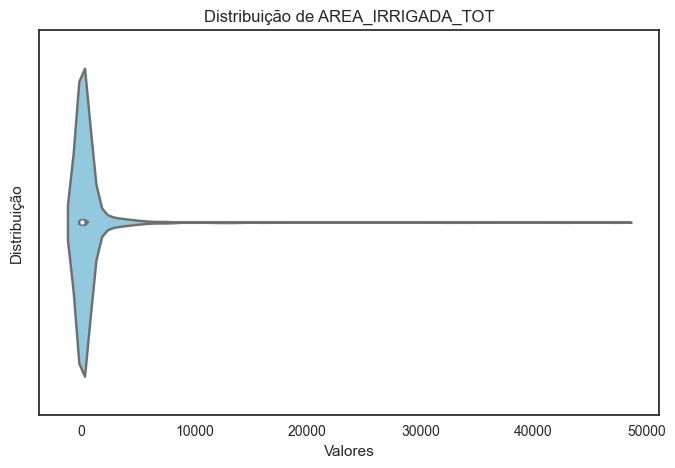

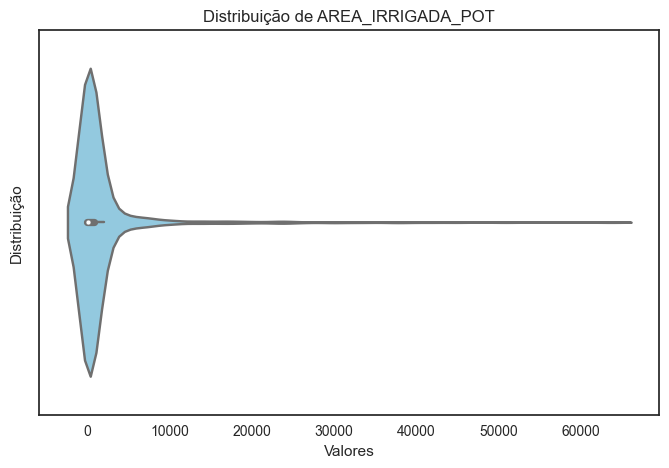

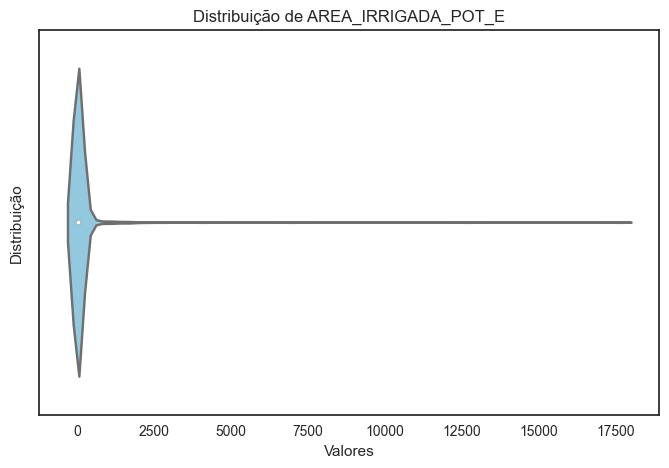

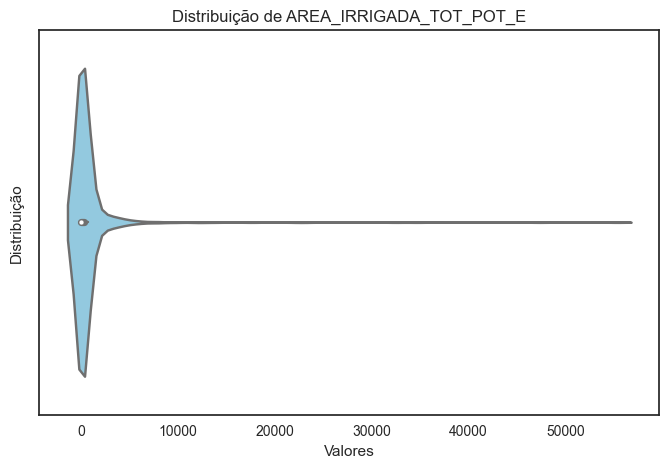

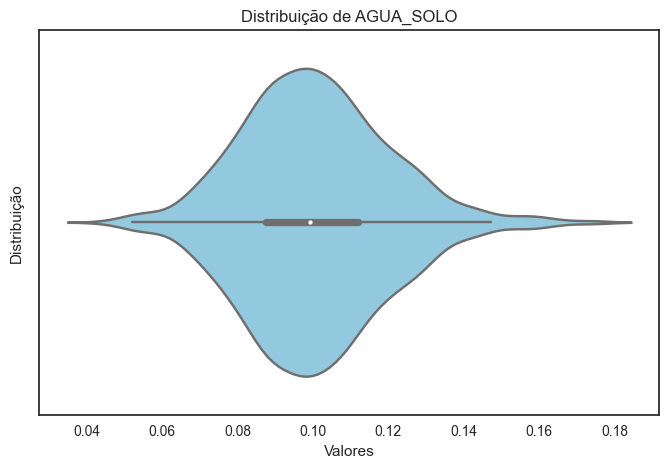

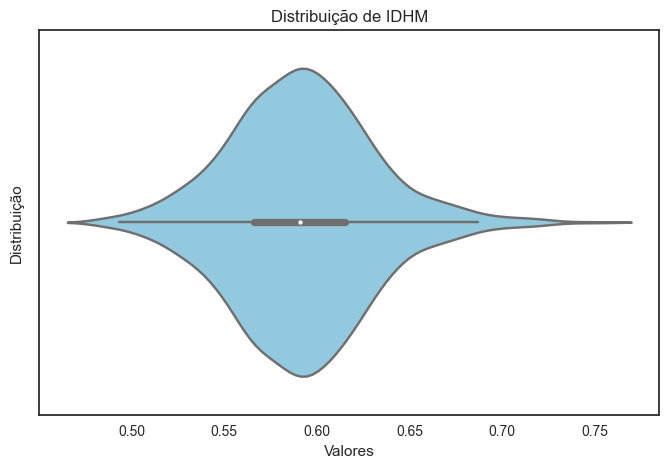

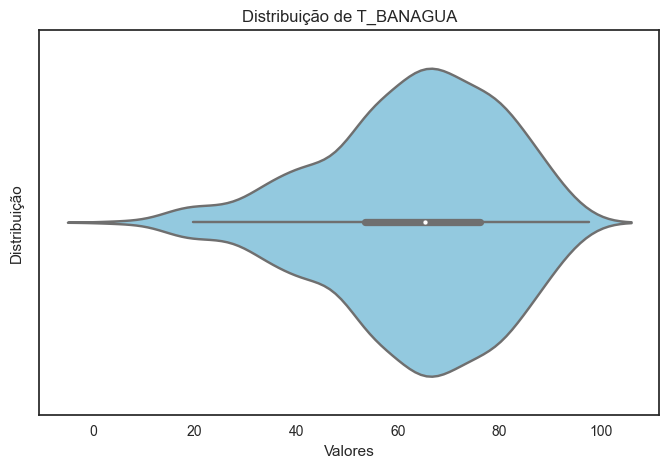

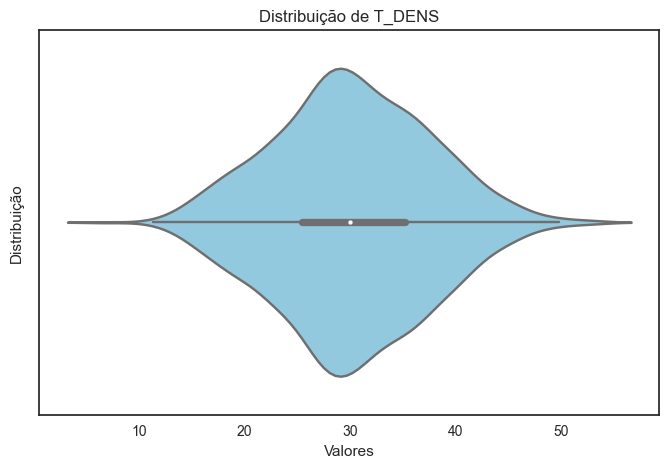

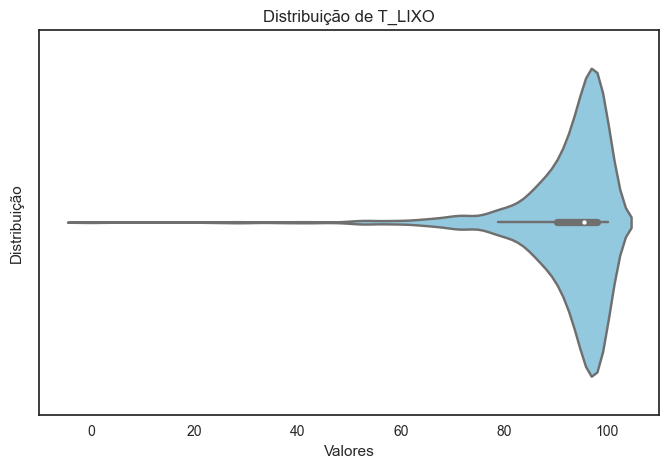

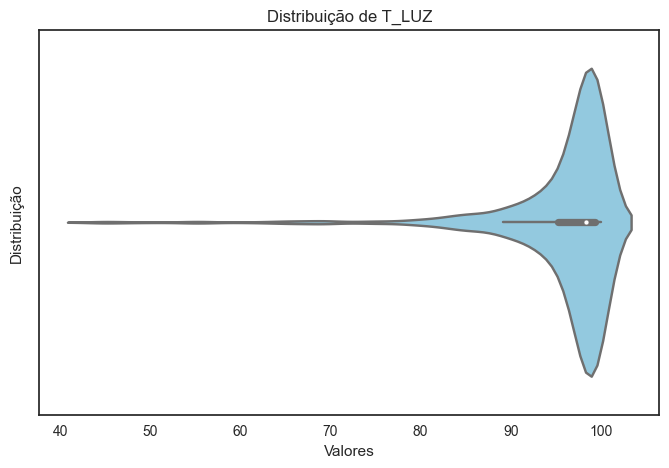

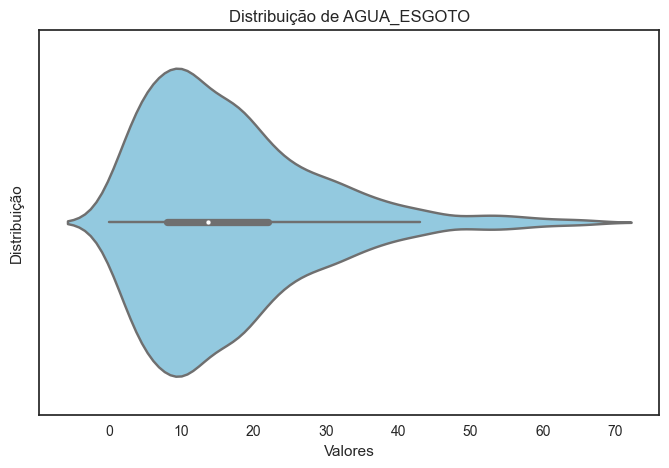

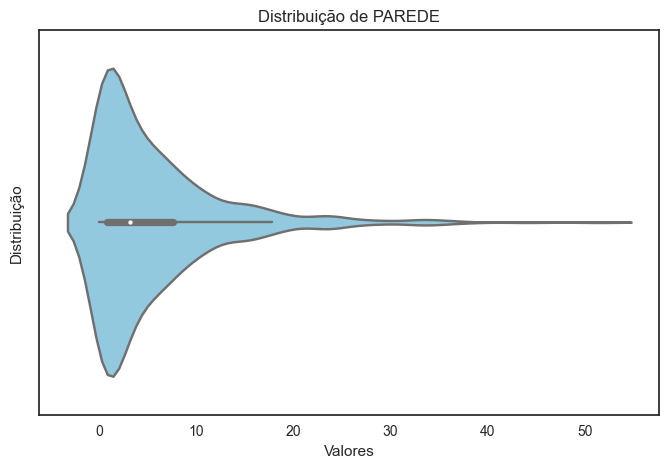

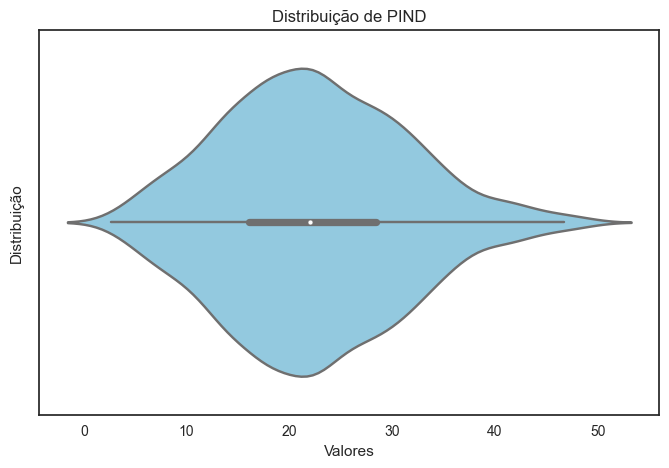

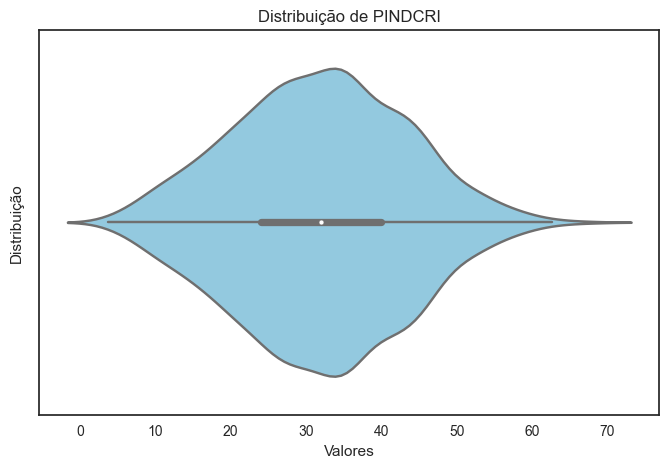

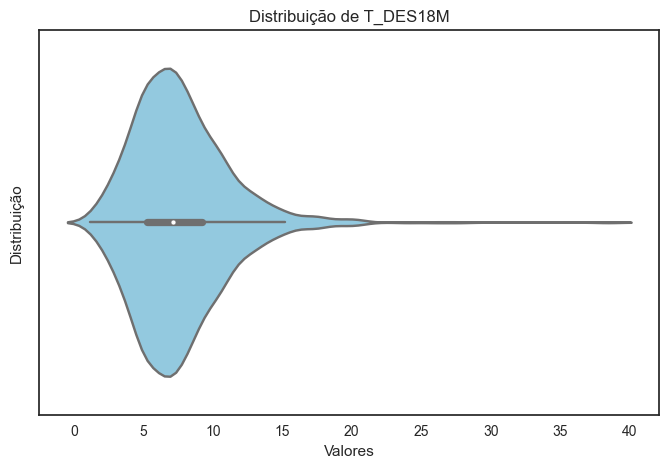

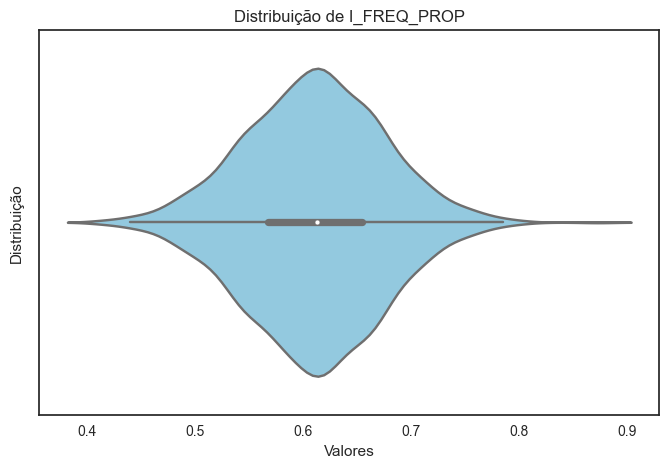

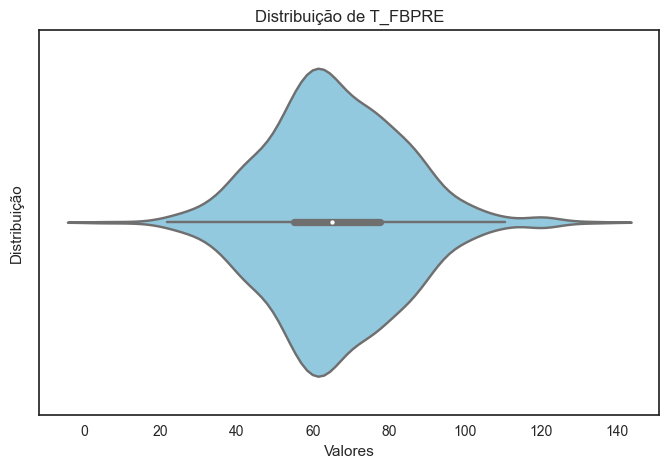

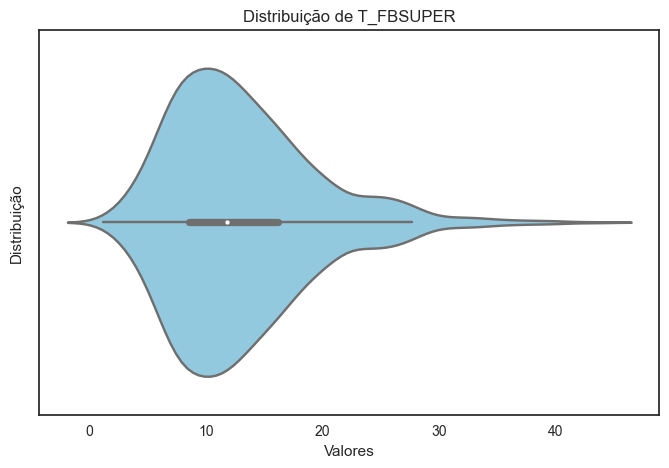

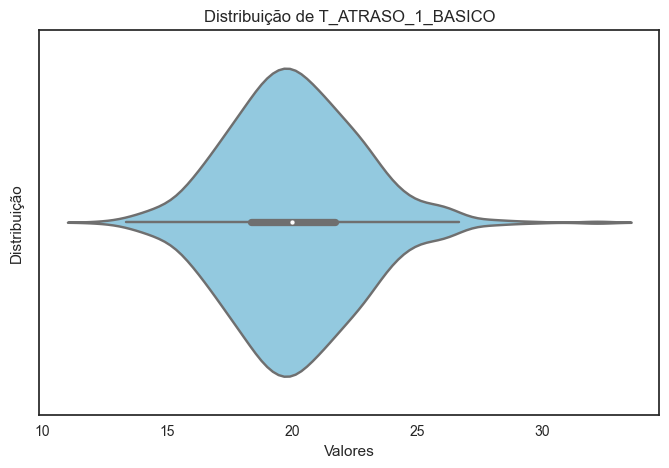

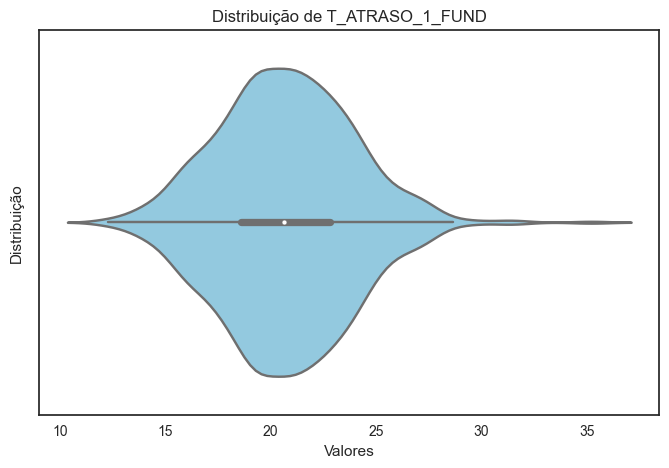

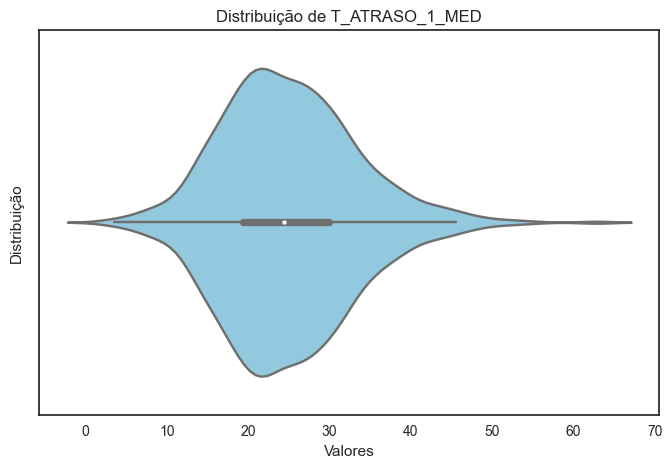

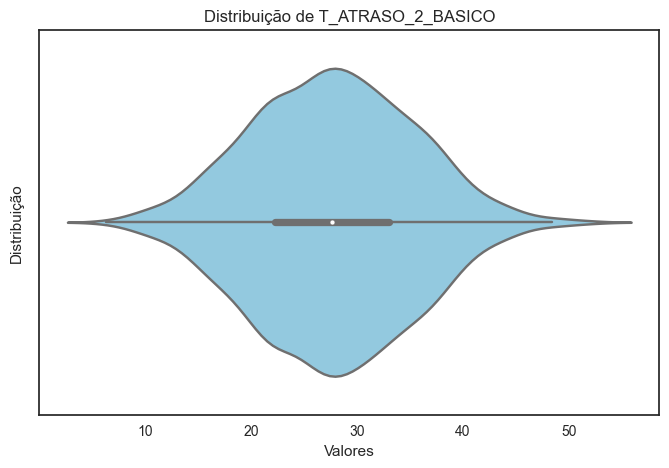

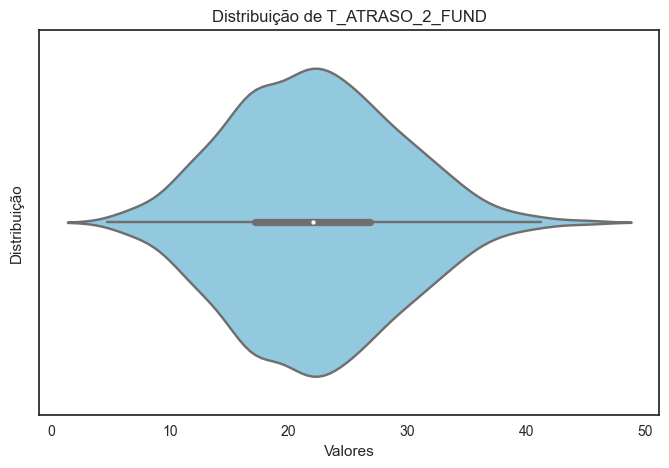

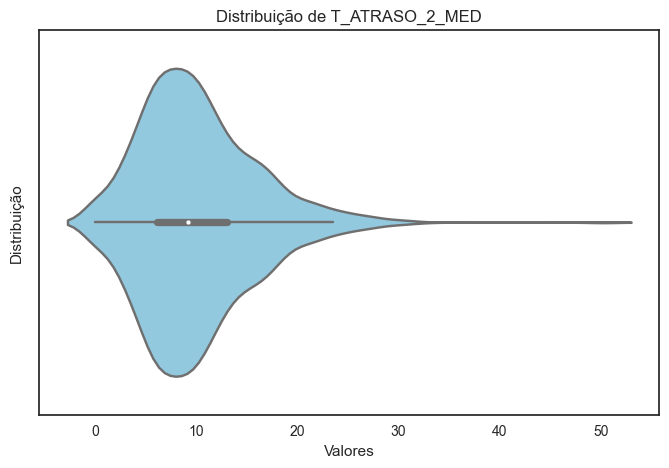

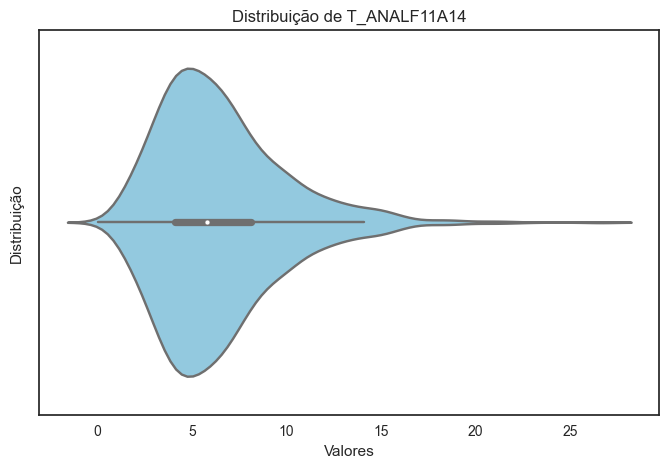

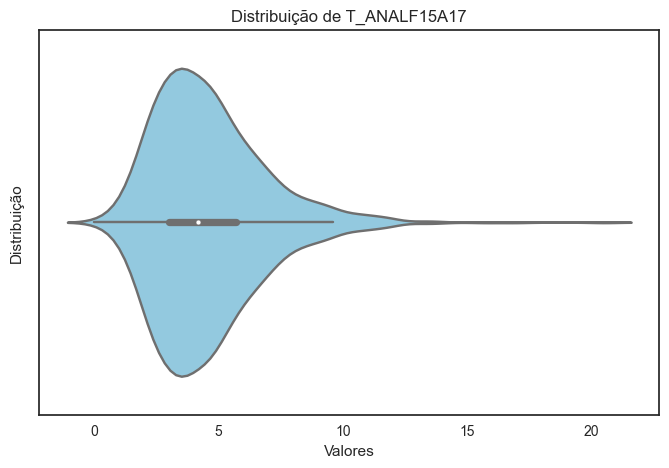

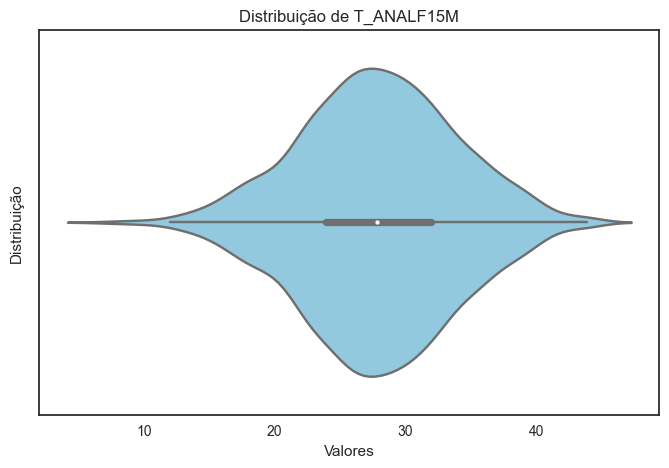

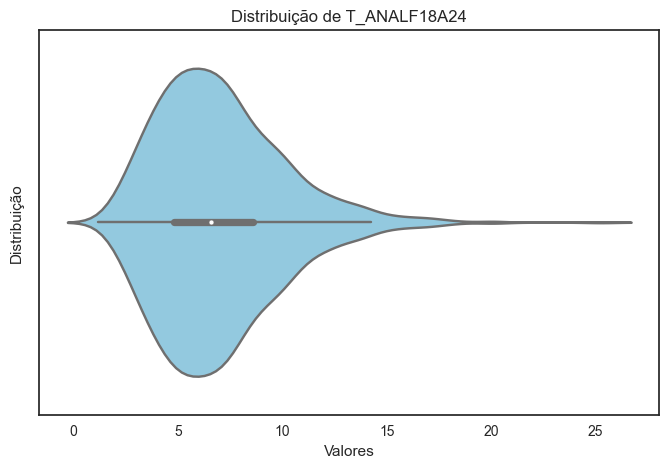

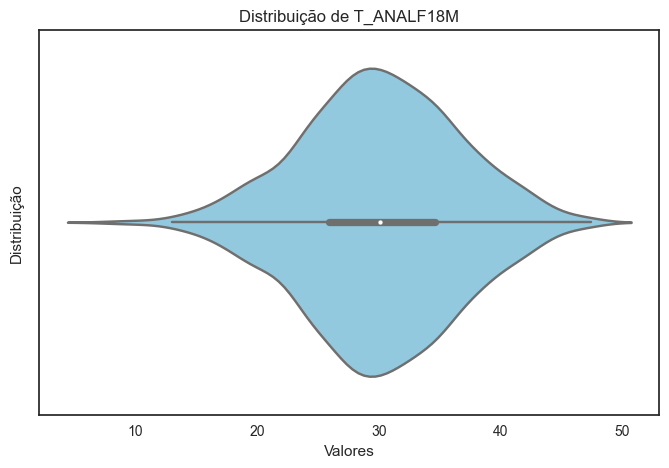

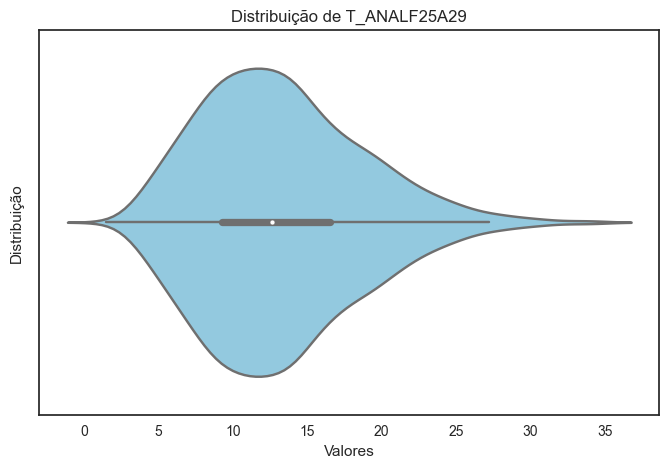

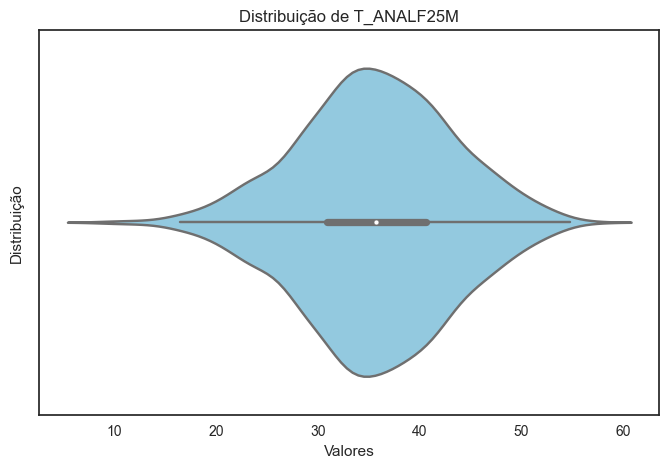

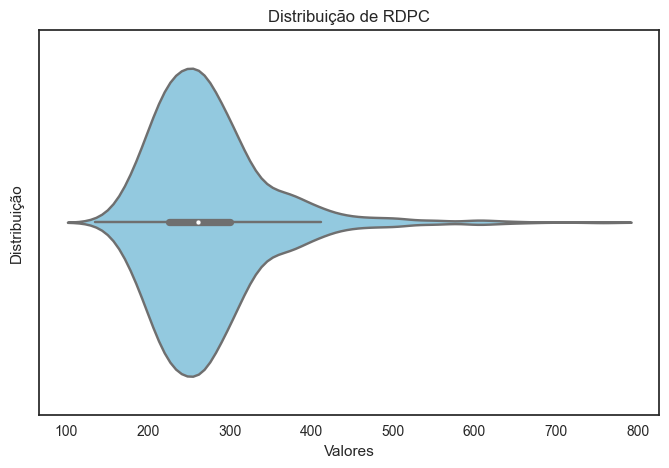

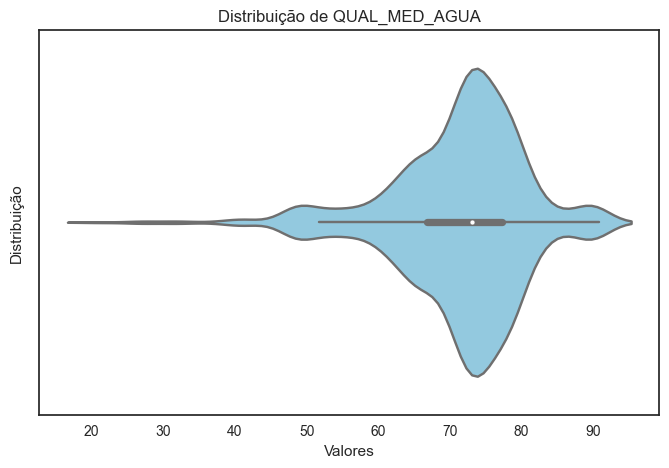

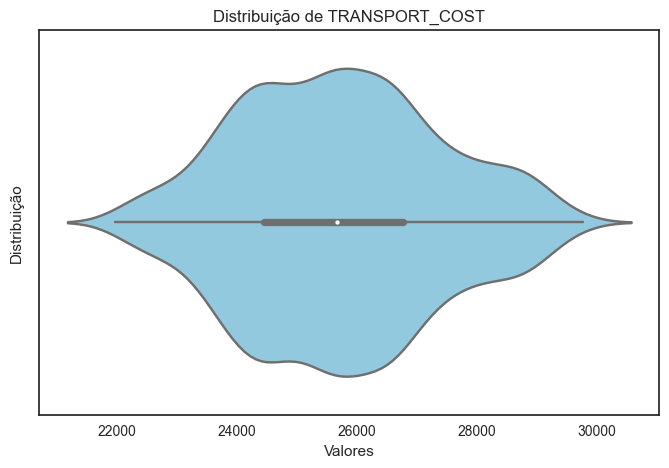

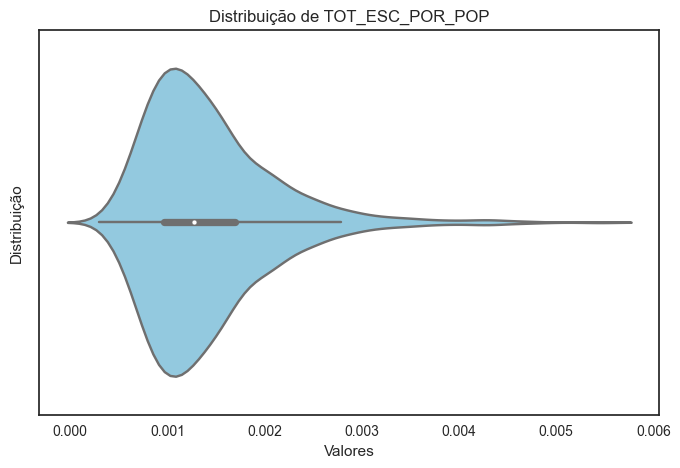

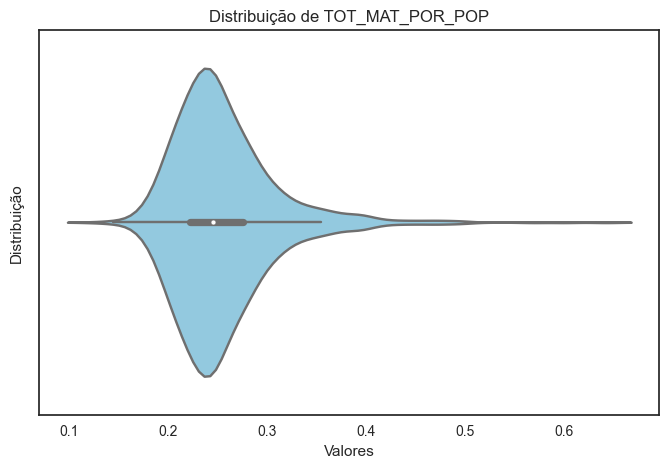

In [3]:
columns = [coluna for coluna in df.columns if (df[coluna].dtype == 'float64')&(coluna not in ['LATITUDE', 'LONGITUDE'])]

for column in columns:
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df[column], color='skyblue')
        
    plt.xlabel('Valores') 
    plt.ylabel('Distribuição')
    plt.title(f'Distribuição de {column}')
    plt.show()

# 3) Redução da dimensinalidade e análise de cluster

## 3.1) Pré-processamento

O StandardScaler foi utilizado para escalonar os dados e permitir seu processamento pelo PCA

In [4]:
df_numeric_features = df[columns].copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_features)

## 3.2) Aplicação do PCA

Para garantir que o conjunto de dados transformado não apresentasse ruídos, foi selecionado um threshold de 0.5 para manter 50% da variância

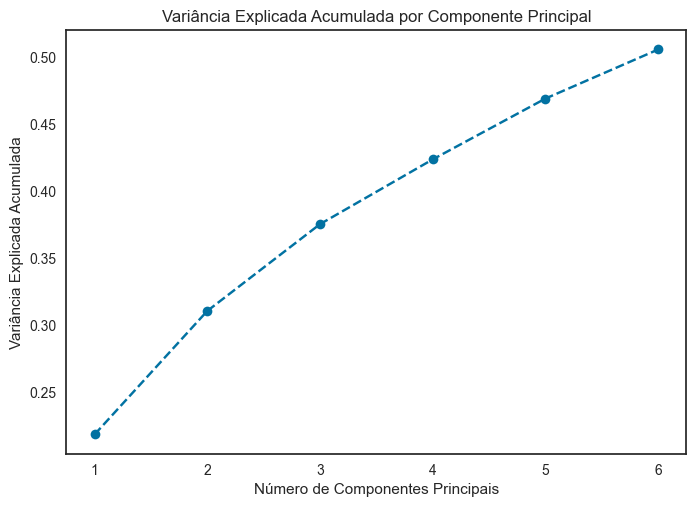

In [5]:
pca = PCA(n_components = 0.50)
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.3) Análise de cluster

Foi criada uma função para realizar a visualização dos clusters em 2 dimensões. Para isso, foi criado um novo PCA com os dois componentes  principais,

In [6]:
PCA_plot = PCA(n_components=2, random_state=42)
df_components = PCA_plot.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

def plot(df, df_components, clusters):
    df = pd.concat([df, df_components], axis = 1)
    df['CLUSTER'] = clusters

    actual_cities = df[
        [
            'NOME', 
            'COMPONENT1', 
            'COMPONENT2', 
            'CLUSTER'
        ]
    ].loc[
        df['NOME'].isin(
            [
                'MAURITI', 
                'SAO JOSE DA TAPERA', 
                'BUIQUE', 
                'INAJA'
            ]
        )
    ]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        hue='CLUSTER', 
        s=80,
    )
    sns.scatterplot(
        data=actual_cities, 
        x='COMPONENT1', 
        y='COMPONENT2', 
        marker = 'X', 
        color='black', 
        s=100, 
        label='Cidades atuais'
    )
    for i, row in actual_cities.iterrows():
        plt.text(row['COMPONENT1'] - 0.5, row['COMPONENT2'] + 0.5, row['NOME'], fontsize=10)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title('Visualização dos Grupos')
    sns.despine()
    plt.show()

### 3.3.2) K-Means

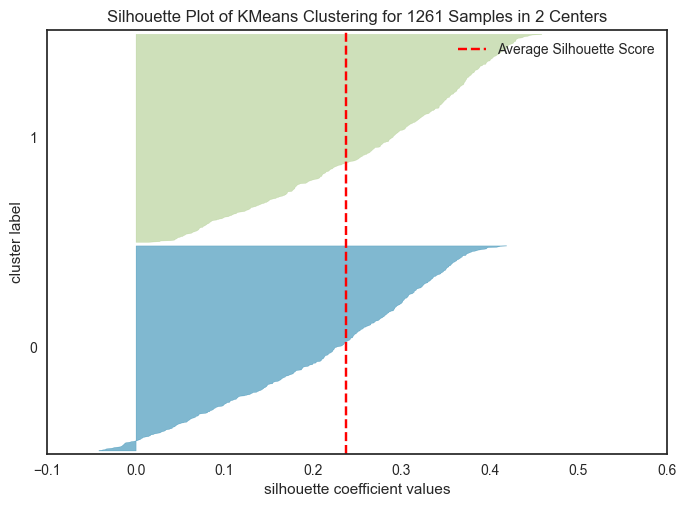

In [7]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.2378
Davies-Bouldin Score:  1.5102
Calinski-Harabasz Index:  458.2511


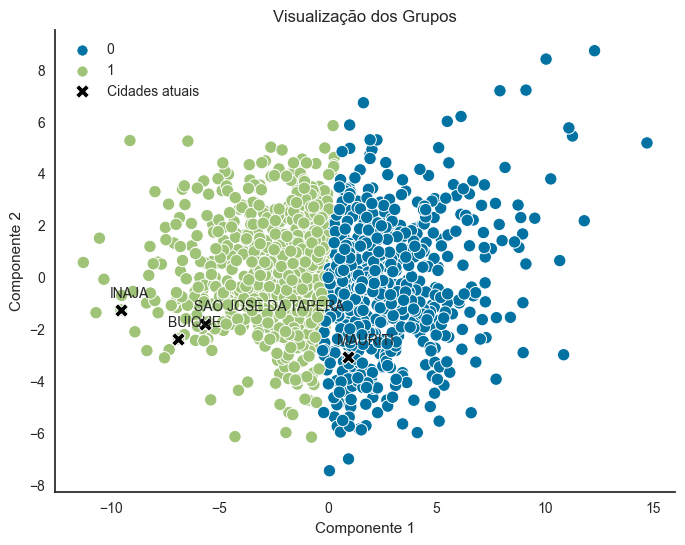

In [8]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção das melhores features

In [9]:
X = df[columns]
y = k_clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_model = RandomForestClassifier(n_jobs=-1, random_state=42)
boruta = BorutaPy(rf_model, n_estimators='auto', verbose=False, random_state=42)
boruta.fit(X_train.values, y_train)
mask_columns_selected = boruta.support_.tolist()
df_pp = X.iloc[:, mask_columns_selected]
columns_selected = df_pp.columns
columns_selected

Index(['DIST_EF_PUB', 'DIST_EM_PUB', 'IDEB_AI', 'IDEB_AF', 'DOCSUP_EF_PUB',
       'DOCSUP_EM_PUB', 'TXNASC7C', 'PDEFAGUA', 'PDEFESGOTO', 'PIND_POS',
       'PMATPUB_EF', 'AGUA_SOLO', 'IDHM', 'T_BANAGUA', 'T_DENS', 'T_LUZ',
       'AGUA_ESGOTO', 'PAREDE', 'PIND', 'PINDCRI', 'I_FREQ_PROP', 'T_FBPRE',
       'T_FBSUPER', 'T_ATRASO_1_BASICO', 'T_ATRASO_1_FUND', 'T_ATRASO_1_MED',
       'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_ATRASO_2_MED',
       'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24',
       'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'RDPC', 'TOT_ESC_POR_POP'],
      dtype='object')

## 3.5) Pré-processamento

In [10]:
df_best_features = df[columns_selected].copy()
df_scaled = scaler.fit_transform(df_best_features)

## 3.6) Nova aplicação do PCA

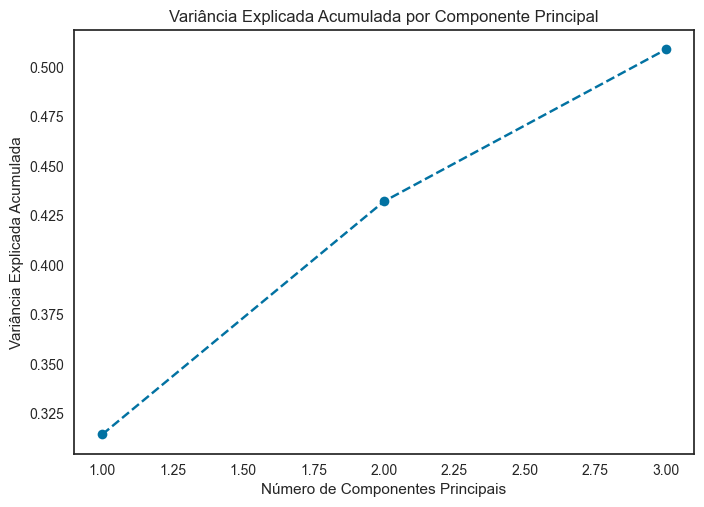

In [11]:
df_reducted = pca.fit_transform(df_scaled)

variancia_explicada = pca.explained_variance_ratio_

variancia_acumulada = np.cumsum(variancia_explicada)
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada por Componente Principal')
plt.show()

## 3.6) Nova análise de cluster

In [12]:
df_components = PCA_plot.fit_transform(df_scaled)
df_components = pd.DataFrame(df_components)
df_components.columns = ['COMPONENT1', 'COMPONENT2']

### 3.6.2) K-Means

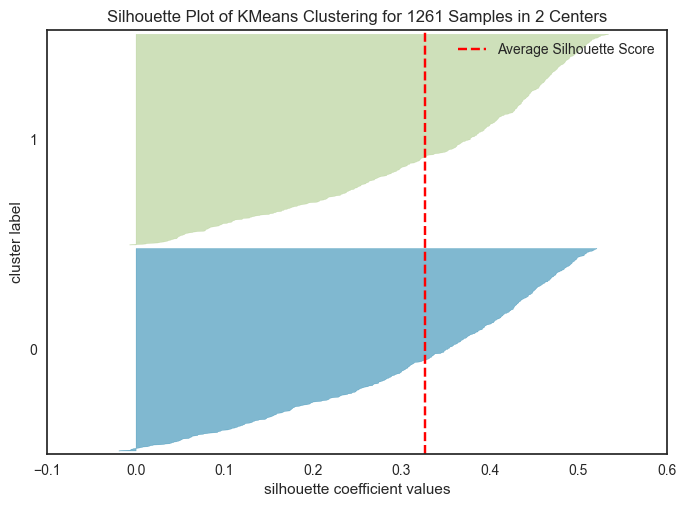

In [13]:
best_score = -1  
best_n_clusters = 0  
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_reducted)
    score = silhouette_score(df_reducted, clusters)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
        
silhouette_visualizer(KMeans(best_n_clusters, random_state=42), df_reducted, colors='yellowbrick')
plt.show()

Silhouette Score:  0.3262
Davies-Bouldin Score:  1.1433
Calinski-Harabasz Index:  799.1746


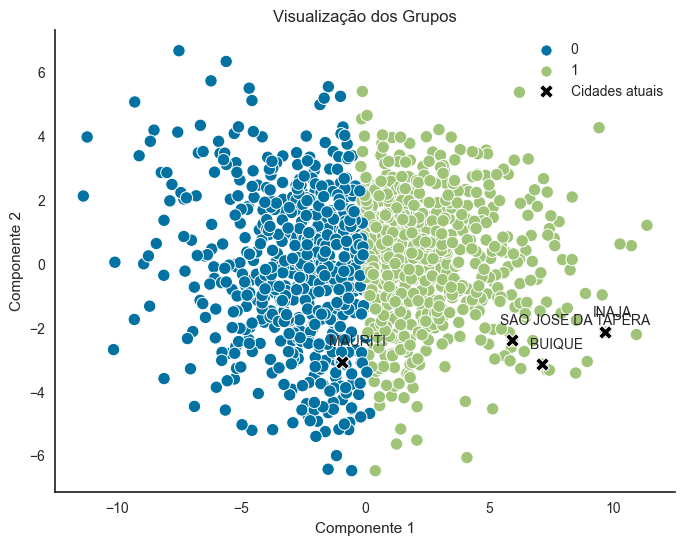

In [14]:
kmeans = KMeans(2, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

## 3.4) Seleção dos municípios com maior potencial

Silhouette Score:  0.2545
Davies-Bouldin Score:  1.1642
Calinski-Harabasz Index:  598.531


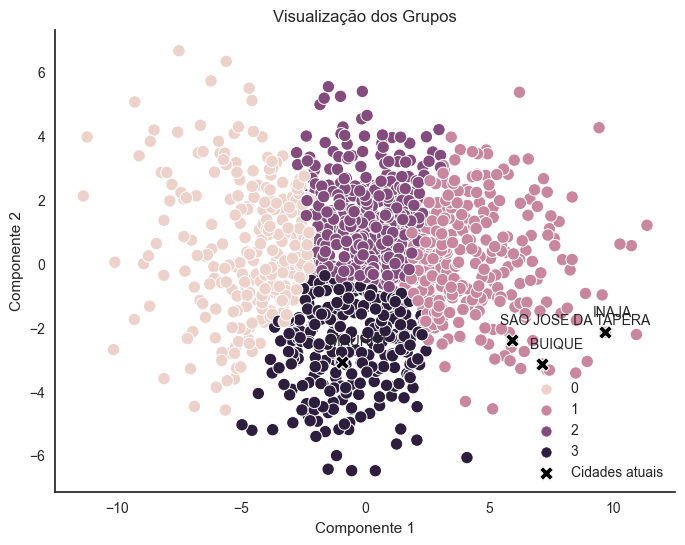

In [15]:
kmeans = KMeans(4, random_state = 42)
k_clusters = kmeans.fit_predict(df_reducted)
print('Silhouette Score: ',round(silhouette_score(df_reducted, k_clusters),4))
print('Davies-Bouldin Score: ',round(davies_bouldin_score(df_reducted, k_clusters),4))
print('Calinski-Harabasz Index: ',round(calinski_harabasz_score(df_reducted, k_clusters),4))
plot(df, df_components, k_clusters)

In [16]:
df['CLUSTER'] = k_clusters
df.to_csv('../Dados/Tabela_final/municipios_clusters.csv')

### 3.4.1) Interpretação dos municípios atuais

In [17]:
actual_cities = df[
    [
        'NOME', 
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'CLUSTER'
    ]
].loc[df['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA'])]

actual_cities

,NOME,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,CLUSTER
34,SAO JOSE DA TAPERA,0.527,32258.8,225558.2,188.84,37.04,0.536,4.33,39.70,1
418,MAURITI,0.605,46103.4,207315.4,236.11,29.51,0.632,8.31,29.78,3
796,BUIQUE,0.527,56502.4,234399.4,176.76,40.18,0.524,7.25,38.73,1
827,INAJA,0.523,21917.0,89734.8,182.73,35.98,0.471,7.35,41.19,1


### 3.4.1) Filtro e interpretação dos clusters

In [18]:
df = pd.read_csv('../Dados/Tabela_final/municipios_clusters.csv')

df = df.loc[(df['POP_TOT'] >= 21917)&(df['POP_TOT_30KM'] >= 89734)]

df[
    [
        'CLUSTER',
        'IDHM',
        'POP_TOT', 
        'POP_TOT_30KM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND'
    ]
].groupby('CLUSTER').mean()

,IDHM,POP_TOT,POP_TOT_30KM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND
CLUSTER,,,,,,,,
0,0.658235,97560.827451,313377.531373,417.452451,19.411961,0.663549,8.329314,10.883431
1,0.548475,35384.045000,197770.365000,229.427250,33.828750,0.529675,6.538000,30.923250
2,0.595426,40248.180328,193307.622951,302.511803,25.591803,0.584230,8.318361,18.969180
3,0.605278,40698.314815,207237.329630,253.462222,28.825000,0.659111,6.761481,25.466852


In [19]:
df['CLUSTER'].value_counts()

CLUSTER
0    102
2     61
3     54
1     40
Name: count, dtype: int64

### 3.4.1) Seleção dos municipios de maior potencial

In [21]:
potential_muns = df.copy()

potential_muns = potential_muns[
    [
        'IBGE7',
        'NOME', 
        'UF',
        'IDHM',
        'RDPC', 
        'T_ANALF15M', 
        'I_FREQ_PROP', 
        'T_DES18M',
        'PIND',
        'IDEB_AI',
        'IDEB_AF',
        'POP_TOT_30KM',
        'POP_TOT'
    ]
].loc[
    (potential_muns['CLUSTER'] == 1)&
    ~(potential_muns['NOME'].isin(['MAURITI', 'SAO JOSE DA TAPERA', 'BUIQUE', 'INAJA']))
].sort_values(by='IDHM').reset_index().drop(columns='index')

potential_muns

,IBGE7,NOME,UF,IDHM,RDPC,T_ANALF15M,I_FREQ_PROP,T_DES18M,PIND,IDEB_AI,IDEB_AF,POP_TOT_30KM,POP_TOT
0,2916500,ITAPICURU,BA,0.486,185.70,38.52,0.462,9.86,31.44,3.912,2.784,197766.2,35881.0
1,2705002,MATA GRANDE,AL,0.504,186.87,38.79,0.499,1.57,41.39,4.152,3.260,129923.6,25555.2
2,2921500,MONTE SANTO,BA,0.506,197.43,35.57,0.494,4.55,35.11,3.796,3.036,107356.8,53678.4
3,2607505,ITAIBA,PE,0.510,218.32,39.73,0.497,4.11,27.48,4.104,3.268,129160.2,26440.2
4,2615805,TUPANATINGA,PE,0.519,172.52,38.41,0.513,5.31,45.08,5.200,3.564,135832.6,26445.0
5,2100907,ARAIOSES,MA,0.521,175.81,33.70,0.530,7.70,40.55,3.892,3.292,278943.2,45225.2
6,2603207,CAETES,PE,0.522,176.77,38.63,0.530,3.82,42.77,4.584,3.660,275058.0,28139.2
7,2702355,CRAIBAS,AL,0.525,199.54,39.67,0.554,2.73,30.89,4.000,2.916,452771.8,24250.4
8,2600500,AGUAS BELAS,PE,0.526,239.30,40.23,0.484,6.76,31.96,4.356,3.904,120915.8,42556.6
9,2805406,POCO REDONDO,SE,0.529,202.24,35.58,0.489,6.55,36.41,3.640,3.176,160430.8,33748.0
